In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt


## Metropolis-Hasting 
Implement the Metropolis-Hasting algorithm to estimate the distributions of parameters given a set of observations about the distribution that may have generated your data.

Consider a set of observations generated according to a mixture of 3 two-dimensional Gaussians:

$$ p(\mathbf{x}\mid\theta) = \sum_{k=1}^3 w_k \cdot \mathcal{N}(\mathbf{x}\mid \mu_k, \Sigma_k),$$

where $\mu_k = [\mu_k^{(1)}, \mu_k^{(2)}]$ and $\Sigma_k$ is the $2\times 2$ precision matrix. Here $\theta = \{(w_i,\mu_i,\Sigma_i)\}_{i=1}^3$.

**REMARK:** The model $p(\mathbf{x}\mid\theta)$ is a distribution over $\mathcal{X}$, i.e., a sample from it is an an observation $\mathbf{x}$. Whereas, the distribution $p(\theta\mid\mathcal{D})$ is a distribution over $\Theta$, i.e., each sample from it is a parameter $\theta$.

### Generate dataset
Choose a set of parameters and generate samples from the resulting distribtion. The goal is to learn a distribution over the parameters space that capture well the real parameters.

In [2]:
def sample_from_model(theta, n_samples):
    ni = int(n_samples/3)
    mu_1 = theta[0:2]
    mu_2 = theta[2:4]
    mu_3 = theta[4:6]
    dim = mu_1.shape[0]
    cov_matrix_1 = np.diag(theta[6]*np.ones(dim))
    cov_matrix_2 = np.diag(theta[7]*np.ones(dim))
    cov_matrix_3 = np.diag(theta[8]*np.ones(dim))
    
    samples_1=scipy.stats.multivariate_normal.rvs(mu_1,cov_matrix_1, ni)
    samples_2=scipy.stats.multivariate_normal.rvs(mu_2,cov_matrix_2, ni)
    samples_3=scipy.stats.multivariate_normal.rvs(mu_3,cov_matrix_3, ni)
    
    samples = np.vstack((samples_1,samples_2,samples_3))
    return samples

In [3]:
real_param = np.array([1,4,4,1,6,6,1.5,2,3])
observations = sample_from_model(real_param, n_samples = 3000)

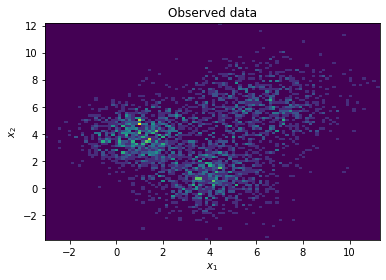

In [4]:
plt.hist2d(observations[:,0], observations[:,1], bins=100)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Observed data")
plt.show()

### Metro Polis Hastings Algorithm


In [5]:
def transition_model(curr_theta):
    c = 0.1
    new_theta = np.random.uniform(curr_theta-c, curr_theta+c)
    while(np.any(new_theta) < 0):
        new_theta = np.random.uniform(curr_theta-c, curr_theta+c)
    return new_theta 

In [6]:
def prior(theta):
    if(np.any(theta) <= 0):
        return 0
    return 1

In [7]:
def log_lkh(theta, data):
    mu_1 = theta[0:2]
    mu_2 = theta[2:4]
    mu_3 = theta[4:6]
    dim = mu_1.shape[0]
    cov_matrix_1 = np.diag(theta[6]*np.ones(dim))
    cov_matrix_2 = np.diag(theta[7]*np.ones(dim))
    cov_matrix_3 = np.diag(theta[8]*np.ones(dim))
    
    comp_1 = scipy.stats.multivariate_normal(mu_1, cov_matrix_1).pdf(data)
    comp_2 = scipy.stats.multivariate_normal(mu_2, cov_matrix_2).pdf(data)
    comp_3 = scipy.stats.multivariate_normal(mu_3, cov_matrix_3).pdf(data)
    
    return np.sum(np.log((comp_1+comp_2+comp_3)/3))

In [8]:
def acceptance_rule(z, z_new):
    if z_new>z:
        return True
    else:
        u = np.random.uniform(0,1)
        return (u < np.exp(z_new-z))

In [9]:
def metropolis_hastings(lkh_fnc, prior, transition_model, theta_0, traj_len, data, acceptance_rule):
    
    curr_theta = theta_0
    samples = []
    n_acc = 0
    n_rej = 0
    for i in range(traj_len):
        new_theta = transition_model(curr_theta)
        curr_lkh = lkh_fnc(curr_theta,data)
        new_lkh = lkh_fnc(new_theta,data)
        
        if(acceptance_rule(curr_lkh + np.log(prior(curr_theta)), new_lkh + np.log(prior(new_theta)))):
            curr_theta = new_theta
            samples.append(new_theta)
            n_acc += 1
        else:
            samples.append(curr_theta)
            n_rej += 1
    print("chain generated", n_rej)
    return samples, n_rej

In [12]:
n_param = 9
theta_0 = np.random.uniform(0,5, (n_param,))

traj_len = 5000

samples, n_rej = metropolis_hastings(log_lkh, prior, transition_model, theta_0, traj_len, observations, acceptance_rule)

chain generated 4118


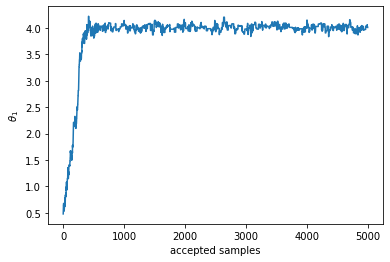

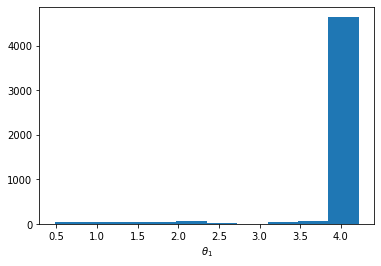

In [13]:
samples = np.asarray(samples)
# first parameter
plt.plot(np.arange(traj_len), samples[:,0])
plt.xlabel("accepted samples")
plt.ylabel("$\\theta_1$")
plt.show()

plt.hist(samples[:, 0])
plt.xlabel("$\\theta_1$")
plt.show()

### Differential Evolution MCMC:

In [14]:
def less_than(a,val):
    c = (a < val)
    boolean = False
    for i in range(c.shape[0]):
        boolean += c[i]
    return boolean

In [87]:
def transition_model1(curr_theta, theta_population, ind):
    N = theta_population.shape[0]
    d = theta_population.shape[1]
    
    gamma = 2.38/np.sqrt(2*d)
    
    a = int(np.random.uniform(0,N))
    while (a == ind):
        a = int(np.random.uniform(0,N))

    b = int(np.random.uniform(0,N))
    while (b == ind or a == b):
        b = int(np.random.uniform(0,N))
    
    theta_a = theta_population[a]
    theta_b = theta_population[b]
        
    var = 1
    eps = np.random.uniform(0,var,size=(d))
    
    new_theta = curr_theta + gamma*(theta_a-theta_b) + eps
    
    while(less_than(new_theta,0)):
        new_theta = transition_model(curr_theta)

    return new_theta

In [88]:
def DE_metropolis_hastings(lkh_fnc, prior, transition_model, theta_population, traj_len, data, acceptance_rule):
    N = theta_population.shape[0]
    all_chains = []
    for j in range(N):
        curr_theta = theta_population[j]
        samples = []
        n_acc = 0
        n_rej = 0
        for i in range(traj_len):
            new_theta = transition_model(curr_theta, theta_population, j)
            #print(new_theta)
            curr_lkh = lkh_fnc(curr_theta,data)
            new_lkh = lkh_fnc(new_theta,data)

            if(acceptance_rule(curr_lkh + np.log(prior(curr_theta)), new_lkh + np.log(prior(new_theta)))):
                curr_theta = new_theta
                theta_population[j] = new_theta
                samples.append(new_theta)
                n_acc += 1
            else:
                samples.append(curr_theta)
                n_rej += 1
        print("chain generated", n_rej)
        all_chains.append(samples)
    return all_chains

In [89]:
N = 10
theta_population = np.zeros((N, n_param))
for i in range(N):
    theta_population[i] = np.random.uniform(0,5, (n_param,))

In [91]:
traj_len = 4000
all_chains = DE_metropolis_hastings(log_lkh, prior, transition_model1, theta_population, traj_len, observations, acceptance_rule)

chain generated 4000
chain generated 3838
chain generated 3801
chain generated 3725
chain generated 3711
chain generated 3715
chain generated 3764
chain generated 3824
chain generated 3775
chain generated 3742


In [92]:
all_chains = np.asarray(all_chains)
all_chains.shape

(10, 4000, 9)

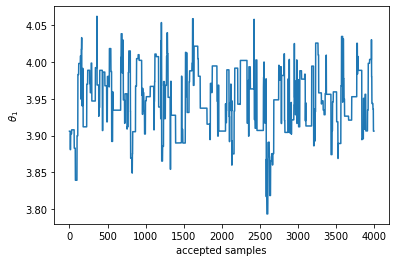

In [108]:
samples = all_chains[9, : , :]
plt.plot(np.arange(traj_len), samples[:,1])
plt.xlabel("accepted samples")
plt.ylabel("$\\theta_1$")
plt.show()

In [94]:
first_sample = sample_from_model(samples[0], 30000)
last_sample = sample_from_model(samples[-1], 30000)

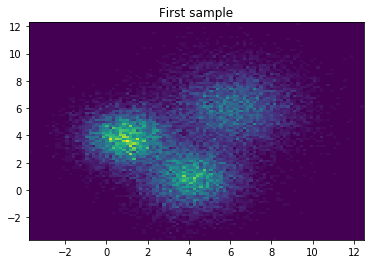

In [95]:
plt.hist2d(first_sample[:,0], first_sample[:,1], bins=100)
plt.title("First sample")
plt.show()

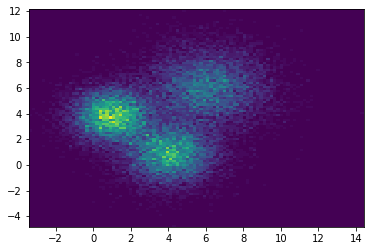

In [96]:
plt.hist2d(last_sample[:,0], last_sample[:,1], bins=100)
plt.show("Last sample")

In [97]:
n = int(traj_len/4)
no_burnin_chains=all_chains[:,2*n:,:]
print(no_burnin_chains.shape)
chains=np.vstack((no_burnin_chains[:,:n,:], no_burnin_chains[:,n:,:]))
print(chains.shape)

(10, 2000, 9)
(20, 1000, 9)


In [98]:
psi = lambda par: log_lkh(par, observations)

In [99]:
def between_variance(chains):
    # chains is a m x n matrix
    m, n, _ = chains.shape
    psi_bar_j = np.zeros(m)
    for i in range(m):
        psi_bar_j[i] = np.mean(np.array([psi(th_i) for th_i in chains[j]]))
    psi_bar = np.mean(psi_bar_j)
    B = np.sum((psi_bar_j-psi_bar)**2)*n/(m-1)
    return B

In [100]:
def within_variance(chains):
    # chains is a m x n matrix
    m, n, _= chains.shape
    bar_psi_j = np.empty(m)
    s_j = np.empty(m)
    for j in range(m):
        psi_ij=np.array([psi(th_i) for th_i in chains[j]])
        bar_psi_j[j] = np.mean(psi_ij)
        s_j[j] = np.sum((psi_ij-bar_psi_j[j])**2)/(n-1)

    W = np.mean(s_j)
    
    return W

In [101]:
def var_plus_psi(chains):
    m,n, _ = chains.shape
    B = between_variance(chains)
    W = within_variance(chains)
    return (W*(n-1)+B)/n

In [102]:
def var_plus_psi_fast(chains):
    m,n, _= chains.shape
    psi_ij = np.array([[psi(th_i) for th_i in chains[j]] for j in range(m)])
    bar_psi_j = np.mean(psi_ij, axis=1)
    bar_psi = np.mean(bar_psi_j)
    B=np.sum((bar_psi_j-bar_psi)**2)*n/(m-1)
    s_j=np.sum((psi_ij-bar_psi_j.reshape(m,1))**2, axis=1)/(n-1)
    W=np.mean(s_j)
    
    return (W*(n-1)+B)/n, W, B

In [103]:
def R_hat(chains):
    W = within_variance(chains)
    var_p = var_plus_psi(chains)
    
    return np.sqrt(var_p/W)

In [104]:
def R_hat_fast(chains):
    var_p, W, _= var_plus_psi_fast(chains)
    return np.sqrt(var_p/W)

In [105]:
print(R_hat_fast(chains))

188.09831862643736
